In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import numpy as np
import allel
import itertools
import os
from subprocess import call
from tqdm import tqdm, trange
from scipy.stats import chi2_contingency

import statsmodels.api as sm
import statsmodels.formula.api as smf

#allows multiple outputs: all, last, last_expr(default), none, last_expr_or_assign
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

#### Step 1: make LD dataframe

In [2]:
#N/A for Bombus

#### Step 2: Chop by 100k window

In [3]:
#this step uses tabix
#this first requires turning vcf to vcf.gz
# bgzip your.vcf
# tabix -p vcf your.vcf.gz <- this makes index
# tabix your.vcf.gz chr1:10,000,000-20,000,000

#bombus has to run in hap-r2


#### Step 3: Calculating Mean-Median R2 per Window

In [4]:
#take all files and make one dataframe
ld_r2 = []

path_folder = '/data3/TaeFile/HapLd/'

for file in tqdm(os.listdir(path_folder), total=len(path_folder)):
    window = file.split('_headered')[0]
    df = pd.read_csv(f'{path_folder}/{file}', sep='\t')
    mean_r2 = df['R^2'].mean()
    median_r2 = df['R^2'].median()
    ld_r2.append([window, mean_r2, median_r2])

#destination of the final file is in home directory = windowed_LD.csv
#condition, hap.ld, with maf 0.2, and window of 60 bp

2461it [00:07, 334.78it/s]                      


In [5]:
df = pd.DataFrame(ld_r2, columns = ['ID', 'r2_mean', 'r2_median'])
display(df.head())

,ID,r2_mean,r2_median
0,NT_177880.1_900000,0.478757,0.428571
1,NT_179893.1_1300000,0.549740,0.428571
2,NT_176548.1_300000,0.464233,0.428571
3,NT_176871.1_300000,0.414016,0.285714
4,NT_176837.1_300000,0.563966,0.444444


#### Step 4: Making the Master Dataframe

In [6]:
#AA caller, based on frequency.
#common, high frequency seen as reference/ancestral
#rarer, low frequency seen as alternative/derived
def AA_caller(frequency, reference, alternative):
    if (frequency > 0.5):
        return alternative
    elif (frequency < 0.5):
        return reference
    else:
        return np.nan

In [7]:
#Mutation direction function "strength_classifier"
strong_bases= ['G', 'C']
weak_bases= ['A', 'T']

def strength_classifier(ancestor, derived):
    if (ancestor in strong_bases) and (derived in weak_bases):
        return 'SW'
    elif (ancestor in weak_bases) and (derived in strong_bases):
        return 'WS'
    else:
        return 'NN'

In [8]:
#Define frequency of the Derived State, the mutation
#if ALT = Derived, keep the original AF, which describes the frequency of the ALT
#if REF = Derived, use 1 - AF

def mutation_frequency (Derived, ALT, AF):
    if Derived == ALT: #this means derived is ALT, which AF is associated with
        return AF
    if Derived != ALT: #this means dervied is REF, which is inversely associated with AF
        return (1-AF)
    else:
        return 'Error'

In [9]:
#Ancestry based on allele frequency
#sorting based on mutation frequency

def barcoder(strength, frequency):
    if (strength == 'SW') and (frequency <= 0.1): #make it less or equal, to be generalizable for different data.
        return 'SW-Rare'
    elif (strength == 'SW') and (0.25 <= frequency <= 0.5):
        return 'SW-Common'
    elif (strength == 'WS') and (frequency <= 0.1):
        return 'WS-Rare'
    elif (strength == 'WS') and (0.25 <= frequency <= 0.5):
        return 'WS-Common'
    else:
        return 'NaN' #keep it this way for Bombus, np.nan causes error downstream, I don't know why.

In [10]:
#execute everything
bombus_things = []

path_folder_2 = '/data3/TaeFile/HeaderedVcf/'

for file in tqdm(os.listdir(path_folder_2), total=len(path_folder_2)):
    window = file.split('_headered')[0]
    
    # Process the file
    df_basket = pd.read_table(f'{path_folder_2}/{file}', sep ='\t', header=None, comment='#')
    df_basket.rename(columns={
        0:"SCAF", 
        1:"POS", 
        2:"Id", 
        3:"REF", 
        4:"ALT", 
        5:"quality", 
        6:"filter", 
        7:"INFO", 
        8:"header", 
        9:"1", 10:"10", 11:"11", 12:"2b", 13:"3", 14:"4", 15:"5", 16:"6", 17:"7", 18:"8"}, 
                     inplace=True)
    column_picks= ["SCAF", "POS", "REF", "ALT", "INFO"]
    df_basket_picks = df_basket[column_picks]
    
    # Get Allele Frequency
    df_basket_picks['AF'] = df_basket_picks['INFO'].str.split('AF=').str.get(1).str.split(';').str.get(0).astype(float)
    df_basket_picks.drop(columns=['INFO'], inplace=True)
    
    #Drop Allele Frequency of 0 and 1
    df_basket_picks = df_basket_picks[df_basket_picks['AF'] != 1.0] #drop all AF of 1
    df_basket_picks = df_basket_picks[df_basket_picks['AF'] != 0] #drop all AF of 0
    
    #AA base calling
    df_basket_picks["AA"] = df_basket_picks.apply(lambda row: AA_caller(row["AF"], row["REF"], row["ALT"]), 
                                                  axis= 'columns')
    df_basket_picks["Derived"] = df_basket_picks.apply(lambda row: AA_caller(row["AF"], row["ALT"], row["REF"]), 
                                                       axis= 'columns')
    
    #Mutation direction
    df_basket_picks['Dirct'] = df_basket_picks.apply(lambda row: strength_classifier(row['REF'], row['ALT']), 
                                                         axis='columns')
    
    #Mutation Frequency, feed the variables in order of Derived, ALT, AF
    df_basket_picks['MF'] = df_basket_picks.apply(lambda row: mutation_frequency(row['Derived'], row['ALT'], row['AF']), 
                                                  axis='columns')
    
    df_basket_picks['Barcode'] = df_basket_picks.apply(lambda row: barcoder(row['Dirct'], row['MF']), axis='columns')
    #Barcoded_Bombus = df_basket_picks[df_basket_picks['Barcode'] != 'NaN'] #drop anything NaN <- this tosses NN
        #this also got rid of any WS and SW that fell in 0.2 and 0.4 freq window. Now it keeps it all. = better
    Barcoded_Bombus = df_basket_picks #maintain variable transition so that I don't have to touch anything downstream
    
    # dr.kent's stats
    SW_Total_freq = (Barcoded_Bombus['Dirct'].values == 'SW').sum()
    WS_Total_freq = (Barcoded_Bombus['Dirct'].values == 'WS').sum()
    NN_Total_freq = (Barcoded_Bombus['Dirct'].values == 'NN').sum()
    SNP_Total = SW_Total_freq + WS_Total_freq + NN_Total_freq
    
    SW_Rare_freq = (Barcoded_Bombus['Barcode'].values == 'SW-Rare').sum()
    WS_Rare_freq = (Barcoded_Bombus['Barcode'].values == 'WS-Rare').sum()
    
    SW_Common_freq = (Barcoded_Bombus['Barcode'].values == 'SW-Common').sum()
    WS_Common_freq = (Barcoded_Bombus['Barcode'].values == 'WS-Common').sum()
    
    bombus_things.append([window, SW_Total_freq, WS_Total_freq, NN_Total_freq, SNP_Total, SW_Rare_freq, WS_Rare_freq, 
                            SW_Common_freq, WS_Common_freq])

  0%|          | 0/27 [00:00<?, ?it/s]/home/taeyoon/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/taeyoon/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
2461it [07:03,  6.02it/s]                      


In [11]:
final_file = pd.DataFrame(bombus_things)
final_file.head()

,0,1,2,3,4,5,6,7,8
0,NT_176463.1_500000,405,212,70,687,242,117,92,58
1,NT_176967.1_1200000,361,142,74,577,241,67,57,49
2,NT_176453.1_600000,746,556,191,1493,382,221,214,199
3,NT_177349.1_900000,265,101,50,416,166,58,55,34
4,NT_176430.1_600000,120,65,26,211,65,30,34,23


In [12]:
len(final_file)

2461

In [13]:
final_file.rename(columns={
        0:"ID", 
        1:"SW_Total", 2:"WS_Total", 3:"NN_Total", 4: "SNP_Total",
        5:"SW_Rare", 6:"WS_Rare", 7:"SW_Common", 8:"WS_Common",}, inplace=True)

#W_Total_freq, WS_Total_freq, NN_Total_freq, SNP_Total, SW_Rare_freq, WS_Rare_freq, SW_Common_freq, WS_Common_freq

In [14]:
final_file.head(5)

,ID,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common
0,NT_176463.1_500000,405,212,70,687,242,117,92,58
1,NT_176967.1_1200000,361,142,74,577,241,67,57,49
2,NT_176453.1_600000,746,556,191,1493,382,221,214,199
3,NT_177349.1_900000,265,101,50,416,166,58,55,34
4,NT_176430.1_600000,120,65,26,211,65,30,34,23


In [15]:
#Start Merging R2 dataframe with the 'final file'
merged_Bombus = df.merge(final_file, on='ID')
Chopped_Bombus = merged_Bombus.dropna() #removes issue downstream
Chopped_Bombus.head(5)

,ID,r2_mean,r2_median,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common
0,NT_177880.1_900000,0.478757,0.428571,467,289,99,855,267,127,117,107
1,NT_179893.1_1300000,0.549740,0.428571,349,194,68,611,214,91,80,62
2,NT_176548.1_300000,0.464233,0.428571,371,133,54,558,245,69,59,36
3,NT_176871.1_300000,0.414016,0.285714,386,203,84,673,239,109,73,59
4,NT_176837.1_300000,0.563966,0.444444,562,360,115,1037,298,165,152,111


In [16]:
len(Chopped_Bombus)

2346

In [17]:
test = final_file[final_file['ID'] == 'NT_177880.1_900000'] #checking if it paired up correctly
test.head()

,ID,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common
2040,NT_177880.1_900000,467,289,99,855,267,127,117,107


### Output

In [18]:
#Run only once!
Chopped_Bombus.to_csv('/home/taeyoon/VcfFiles/LdByWindow/BombusSFiles/Chopped_Bombus.csv', index=False)

In [19]:
Bombus_df = pd.read_csv('/home/taeyoon/VcfFiles/LdByWindow/BombusSFiles/Chopped_Bombus.csv')
Bombus_df.head(8)

,ID,r2_mean,r2_median,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common
0,NT_177880.1_900000,0.478757,0.428571,467,289,99,855,267,127,117,107
1,NT_179893.1_1300000,0.549740,0.428571,349,194,68,611,214,91,80,62
2,NT_176548.1_300000,0.464233,0.428571,371,133,54,558,245,69,59,36
3,NT_176871.1_300000,0.414016,0.285714,386,203,84,673,239,109,73,59
4,NT_176837.1_300000,0.563966,0.444444,562,360,115,1037,298,165,152,111
5,NT_177192.1_0,0.588178,0.642857,474,293,81,848,274,134,128,102
6,NT_176477.1_800000,0.714286,1.000000,46,29,15,90,27,8,6,12
7,NT_176945.1_900000,0.434890,0.285714,636,375,120,1131,346,174,175,129


#### Merge with GC content per Window and Adjust Total Value

In [20]:
Bombus_GC = pd.read_csv('/home/taeyoon/GCContent/BimpGC_ready.csv', sep='\t')
Bombus_GC.head()

,ID,GC_Content
0,NT_176427.1_0,0.296453
1,NT_176427.1_100000,0.260573
2,NT_176427.1_200000,0.296548
3,NT_176429.1_0,0.369374
4,NT_176429.1_100000,0.401534


In [21]:
#merge!
Bombus_GC_df = pd.merge(Bombus_df, Bombus_GC, how='left', on=['ID'])
Bombus_GC_df.head()
len(Bombus_GC_df)

2346

In [22]:
#Adjusted Total values
Bombus_GC_df['SW_T_Adjusted'] = Bombus_GC_df['SW_Total']/Bombus_GC_df['GC_Content']
Bombus_GC_df['WS_T_Adjusted'] = Bombus_GC_df['WS_Total']/(1 - Bombus_GC_df['GC_Content'])

In [23]:
#Lambda, which is SW/WS
Bombus_GC_df['Lambda'] = Bombus_GC_df['SW_T_Adjusted'] / Bombus_GC_df['WS_T_Adjusted']

In [24]:
Bombus_GC_df.head()

,ID,r2_mean,r2_median,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common,GC_Content,SW_T_Adjusted,WS_T_Adjusted,Lambda
0,NT_177880.1_900000,0.478757,0.428571,467,289,99,855,267,127,117,107,0.351114,1330.054200,445.378360,2.986347
1,NT_179893.1_1300000,0.549740,0.428571,349,194,68,611,214,91,80,62,0.360864,967.124397,303.534586,3.186208
2,NT_176548.1_300000,0.464233,0.428571,371,133,54,558,245,69,59,36,0.489595,757.769338,260.577332,2.908040
3,NT_176871.1_300000,0.414016,0.285714,386,203,84,673,239,109,73,59,0.399884,965.279934,338.267934,2.853596
4,NT_176837.1_300000,0.563966,0.444444,562,360,115,1037,298,165,152,111,0.360534,1558.800599,562.969380,2.768891


In [25]:
len(Bombus_GC_df)

2346

In [26]:
#concise, easier viewing
Bombus_view = Bombus_GC_df.drop(columns=[
    'SW_Total','WS_Total','NN_Total','SNP_Total','SW_Rare','WS_Rare','SW_Common','WS_Common'])
Bombus_view.head()

,ID,r2_mean,r2_median,GC_Content,SW_T_Adjusted,WS_T_Adjusted,Lambda
0,NT_177880.1_900000,0.478757,0.428571,0.351114,1330.054200,445.378360,2.986347
1,NT_179893.1_1300000,0.549740,0.428571,0.360864,967.124397,303.534586,3.186208
2,NT_176548.1_300000,0.464233,0.428571,0.489595,757.769338,260.577332,2.908040
3,NT_176871.1_300000,0.414016,0.285714,0.399884,965.279934,338.267934,2.853596
4,NT_176837.1_300000,0.563966,0.444444,0.360534,1558.800599,562.969380,2.768891


In [27]:
#mean of lambda
Bombus_view['Lambda'].mean()

2.9146375034374357

In [28]:
#GC content unadjusted
(Bombus_GC_df['SW_Total']/Bombus_GC_df['WS_Total']).mean()

1.7271009237689972

### S1: Looking at Total numbers

In [29]:
#name the the final table to work with x, drop possible NaNs
x = Bombus_GC_df.dropna()
len(x)

2346

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


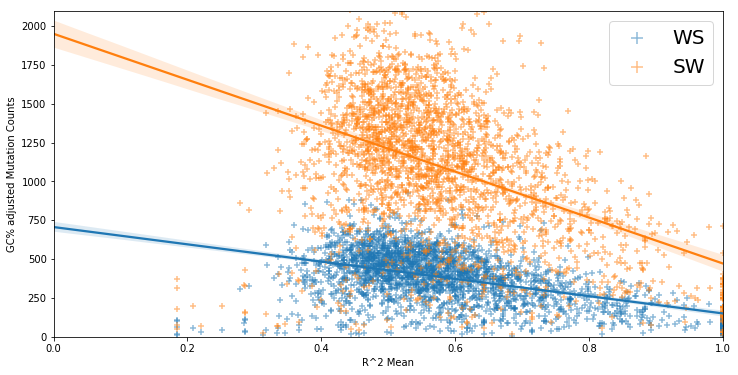

In [30]:
#plot WS and SW together
plt.figure(figsize=(12,6))
plt.ylim(0,2100)
plt.xlim(0,1)

#WS is blue
WST_adj = sns.regplot(x['r2_mean'], x['WS_T_Adjusted'], marker="+", scatter_kws={'alpha':0.5}, label='WS') 

#SW is orange
sns.regplot(x['r2_mean'], x['SW_T_Adjusted'], marker="+", scatter_kws={'alpha':0.5}, label='SW') 

plt.ylabel('GC% adjusted Mutation Counts')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [31]:
scipy.stats.linregress(x['r2_mean'], x['WS_T_Adjusted'])#WS is blue

LinregressResult(slope=-556.3163997919412, intercept=706.5769117131116, rvalue=-0.4561160769896605, pvalue=6.857054916492992e-121, stderr=22.419131687548198)

In [32]:
scipy.stats.linregress(x['r2_mean'], x['SW_T_Adjusted']) #SW is orange

LinregressResult(slope=-1479.556418050194, intercept=1950.9328492958698, rvalue=-0.4443205663429549, pvalue=4.249227141578407e-114, stderr=61.61696031931891)

In [33]:
#Z-test for coefficients (slopes)
def Z_score(slope1, std_error1, slope2, std_error2):
    numerator = (slope1 - slope2)
    denominator = pow((pow(std_error1,2) + pow(std_error2,2)), 1/2)
    Z = (numerator) / (denominator)
    return Z

In [69]:
#Z_score, input order in slope1, std_error1, slope2, std_error2
Z_score(-556.3163997919412, 22.419131687548198, -1479.556418050194, 61.61696031931891)
#Z score: 14.08047801884966
#p-value: 5.007e-45, reject null

14.08047801884966

#### Unadjusted

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


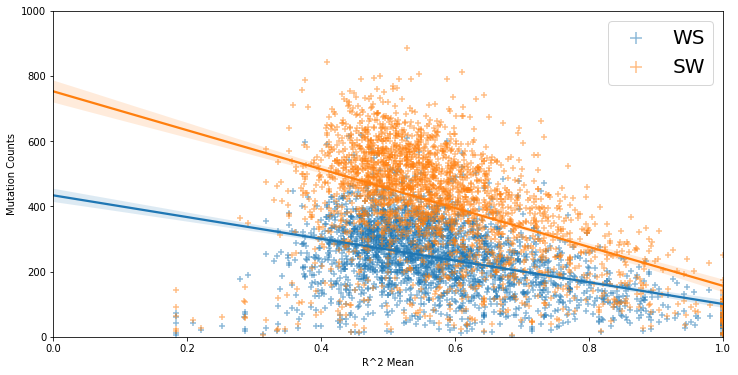

In [35]:
#unadjusted values
#plot WS and SW together
plt.figure(figsize=(12,6))
plt.ylim(0,1000)
plt.xlim(0,1)

#WS is blue
WST_adj = sns.regplot(x['r2_mean'], x['WS_Total'], marker="+", scatter_kws={'alpha':0.5}, label='WS') 

#SW is orange
sns.regplot(x['r2_mean'], x['SW_Total'], marker="+", scatter_kws={'alpha':0.5}, label='SW') 

plt.ylabel('Mutation Counts')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [36]:
scipy.stats.linregress(x['r2_mean'], x['WS_Total']) #WS is blue

LinregressResult(slope=-333.0772246646324, intercept=433.6462546201507, rvalue=-0.42683308540466086, pvalue=1.646839376594595e-104, stderr=14.575893956648743)

In [37]:
scipy.stats.linregress(x['r2_mean'], x['SW_Total']) #SW is orange

LinregressResult(slope=-596.2502791390713, intercept=752.5097653131646, rvalue=-0.4903480254268226, pvalue=3.4978200064433175e-142, stderr=21.889007231972794)

In [71]:
#Z_score, input order in slope1, std_error1, slope2, std_error2
Z_score(-333.0772246646324, 14.575893956648743, -596.2502791390713, 21.889007231972794)
#Z score: 10.00733728308455
#p-value: 1.415e-23, reject null

10.00733728308455

### Lambda

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


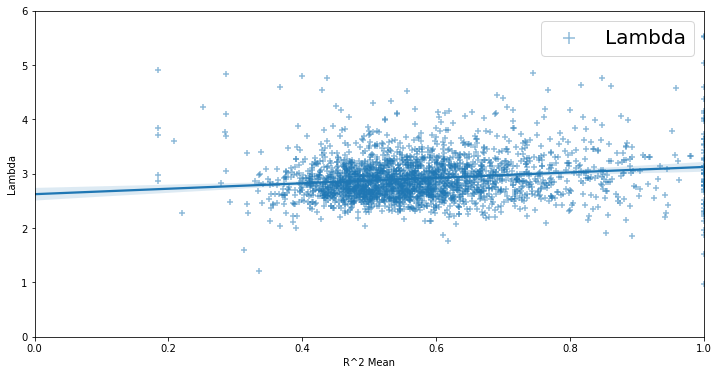

In [39]:
#SW/WS, adjusted
plt.figure(figsize=(12,6))
plt.ylim(0,6)
plt.xlim(0,1)

WST_adj = sns.regplot(x['r2_mean'], x['Lambda'], marker="+", scatter_kws={'alpha':0.5}, label='Lambda') 
scipy.stats.linregress(x['r2_mean'], x['Lambda']) 

plt.ylabel('Lambda')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [40]:
scipy.stats.linregress(x['r2_mean'], x['Lambda']) 

LinregressResult(slope=0.5009389623532539, intercept=2.623716851082038, rvalue=0.16341861288974802, pvalue=1.656986752788897e-15, stderr=0.06246353965820388)

#### Unadjusted Lambda

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


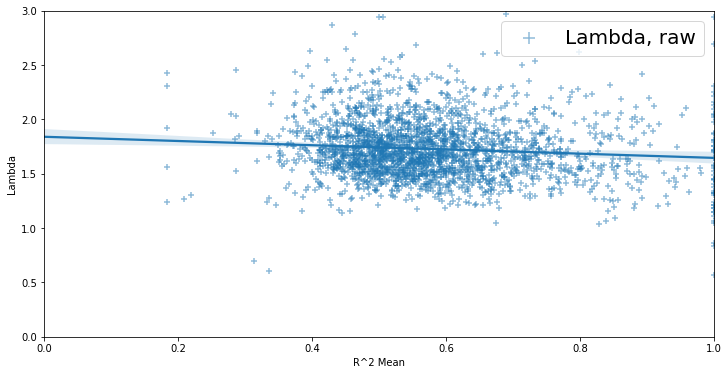

In [41]:
#unadjusted SW/WS
plt.figure(figsize=(12,6))
plt.ylim(0,3)
plt.xlim(0,1)

WST_adj = sns.regplot(x['r2_mean'], x['SW_Total']/x['WS_Total'], marker="+", 
                      scatter_kws={'alpha':0.5}, label='Lambda, raw') 

plt.ylabel('Lambda')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [42]:
scipy.stats.linregress(x['r2_mean'], x['SW_Total']/x['WS_Total']) 

LinregressResult(slope=-0.19405670148106527, intercept=1.8397994887270905, rvalue=-0.09352314976237842, pvalue=5.695850020673922e-06, stderr=0.04267004156419789)

### S2: The 10%, Rares

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


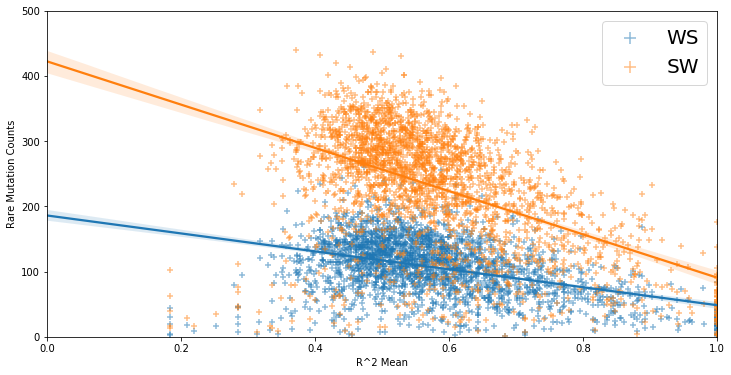

In [43]:
#Plot rare occuring mutations both direction (SW and WS)
plt.figure(figsize=(12,6))
plt.ylim(0,500)
plt.xlim(0,1)

#WS is blue
WST_adj = sns.regplot(x['r2_mean'], x['WS_Rare'], marker="+", scatter_kws={'alpha':0.5}, label='WS') 

#SW is orange
sns.regplot(x['r2_mean'], x['SW_Rare'], marker="+", scatter_kws={'alpha':0.5}, label='SW') 

plt.ylabel('Rare Mutation Counts')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [44]:
scipy.stats.linregress(x['r2_mean'], x['WS_Rare']) #WS is blue

LinregressResult(slope=-137.42182589971887, intercept=185.96383162783593, rvalue=-0.42938572126042596, pvalue=7.111536811438258e-106, stderr=5.97001400336962)

In [45]:
scipy.stats.linregress(x['r2_mean'], x['SW_Rare']) #SW is orange

LinregressResult(slope=-331.3243591219772, intercept=422.2220533727483, rvalue=-0.508954031294369, pvalue=8.187504682677784e-155, stderr=11.574309307219929)

In [72]:
#Z_score, input order in slope1, std_error1, slope2, std_error2
Z_score(-137.42182589971887, 5.97001400336962, -331.3243591219772, 11.574309307219929)
#Z score: 14.88892207971511
#p-value: 3.89e-50, reject null

14.88892207971511

#### Adjusted (note, order reversed)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


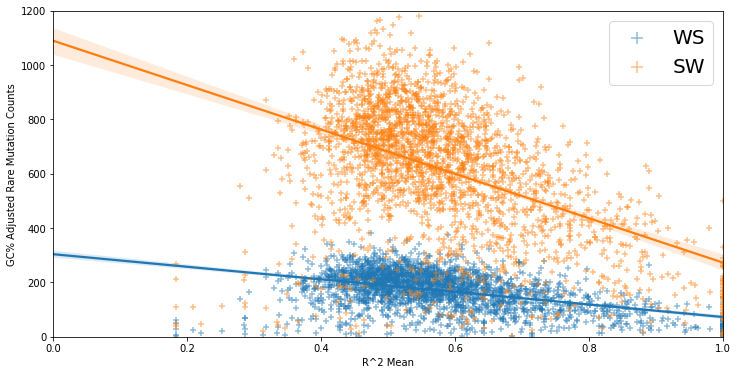

In [47]:
#adjusted for GC%
plt.figure(figsize=(12,6))
plt.ylim(0,1200)
plt.xlim(0,1)

#WS is blue
WST_adj = sns.regplot(x['r2_mean'], x['WS_Rare']/(1 - x['GC_Content']), marker="+", scatter_kws={'alpha':0.5}, label='WS') 

#SW is orange
sns.regplot(x['r2_mean'], x['SW_Rare']/x['GC_Content'], marker="+", scatter_kws={'alpha':0.5}, label='SW') 

plt.ylabel('GC% Adjusted Rare Mutation Counts')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [48]:
scipy.stats.linregress(x['r2_mean'], x['WS_Rare']/(1 - x['GC_Content'])) #WS is blue

LinregressResult(slope=-231.09078524314677, intercept=303.8297855285359, rvalue=-0.45877441495583876, pvalue=1.8540048209490418e-122, stderr=9.244594424933686)

In [49]:
scipy.stats.linregress(x['r2_mean'], x['SW_Rare']/x['GC_Content']) #SW is orange

LinregressResult(slope=-816.0914951965949, intercept=1089.0054984365977, rvalue=-0.4740482797645255, pvalue=9.654935569668344e-132, stderr=31.308788830152398)

In [73]:
#Z_score, input order in slope1, std_error1, slope2, std_error2
Z_score(-231.09078524314677, 9.244594424933686, -816.0914951965949, 31.308788830152398)
#Z score: 17.920013931749107
#p-value: 8.231e-72, two-tailed, reject null

17.920013931749107

### S3: The 50%, Common

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


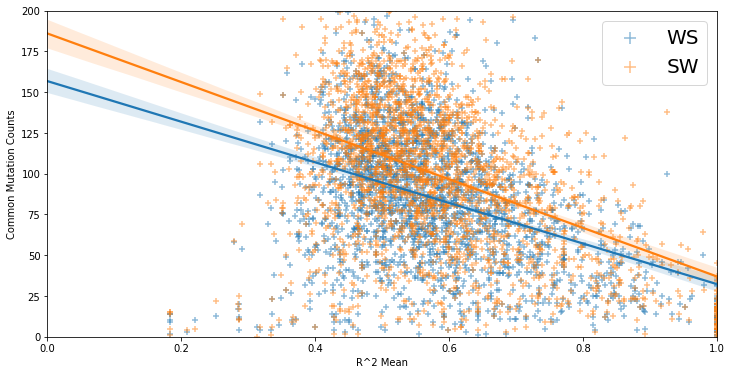

In [51]:
#Common, both directions
plt.figure(figsize=(12,6))
plt.ylim(0,200)
plt.xlim(0,1)

#WS is blue
WST_adj = sns.regplot(x['r2_mean'], x['WS_Common'], marker="+", scatter_kws={'alpha':0.5}, label='WS') 

#SW is orange
sns.regplot(x['r2_mean'], x['SW_Common'], marker="+", scatter_kws={'alpha':0.5}, label='SW') 

plt.ylabel('Common Mutation Counts')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [52]:
scipy.stats.linregress(x['r2_mean'], x['WS_Common']) #WS is blue

LinregressResult(slope=-124.50003857900936, intercept=156.79623800685283, rvalue=-0.4051240660062041, pvalue=2.2789002919868256e-93, stderr=5.803275326954651)

In [53]:
scipy.stats.linregress(x['r2_mean'], x['SW_Common']) #SW is orange

LinregressResult(slope=-149.01341361218874, intercept=186.01278983990397, rvalue=-0.4217436855773332, pvalue=7.99241126821469e-102, stderr=6.617117051168298)

In [54]:
#Z_score, input order in slope1, std_error1, slope2, std_error2
Z_score(-124.50003857900936, 5.803275326954651, -149.01341361218874, 6.617117051168298)
#Z score: 2.7851748838878825
#p-value: 0.00535, reject null

2.7851748838878825

#### Adjusted for GC content (note reversed order)

/home/taeyoon/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


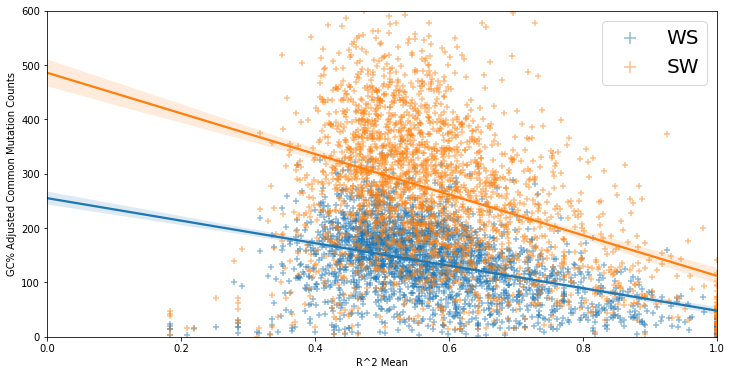

In [55]:
#adjusted for GC%
plt.figure(figsize=(12,6))
plt.ylim(0,600)
plt.xlim(0,1)

#WS is blue
WST_adj = sns.regplot(x['r2_mean'], x['WS_Common']/(1 - x['GC_Content']), marker="+", scatter_kws={'alpha':0.5}, label='WS') 

#SW is orange
sns.regplot(x['r2_mean'], x['SW_Common']/x['GC_Content'], marker="+", scatter_kws={'alpha':0.5}, label='SW') 

plt.ylabel('GC% Adjusted Common Mutation Counts')
plt.xlabel('R^2 Mean')
plt.legend(loc='upper right', prop={'size': 20}, markerscale=2)

In [56]:
scipy.stats.linregress(x['r2_mean'], x['WS_Common']/(1 - x['GC_Content'])) #WS is blue

LinregressResult(slope=-206.97054727948316, intercept=255.0806678655328, rvalue=-0.4306479061473924, pvalue=1.4887541143332978e-106, stderr=8.95909717632094)

In [57]:
scipy.stats.linregress(x['r2_mean'], x['SW_Common']/x['GC_Content']) #SW is orange

LinregressResult(slope=-373.4737218168506, intercept=485.77298018730653, rvalue=-0.3748532326917407, pvalue=3.708942529269663e-79, stderr=19.07827699119179)

In [68]:
#Z_score, input order in slope1, std_error1, slope2, std_error2
Z_score(-206.97054727948316, 8.95909717632094, -373.4737218168506, 19.07827699119179)
#Z score: 7.899702175042606
#p-value: 2.796e-15, reject null

7.899702175042606

### Two window comparison, Odds Ratio

In [59]:
#selecting for datapoints within the window or r2_mean 0.35~0.45 and 0.7~0.9
bombus_slice_1 = x[x['r2_mean'].between(0.35, 0.45, inclusive=True)];
bombus_slice_2 = x[x['r2_mean'].between(0.7,0.9, inclusive=True)];

In [60]:
bombus_slice_1.head()

,ID,r2_mean,r2_median,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common,GC_Content,SW_T_Adjusted,WS_T_Adjusted,Lambda
3,NT_176871.1_300000,0.414016,0.285714,386,203,84,673,239,109,73,59,0.399884,965.279934,338.267934,2.853596
7,NT_176945.1_900000,0.434890,0.285714,636,375,120,1131,346,174,175,129,0.384204,1655.371265,608.967749,2.718323
9,NT_176463.1_0,0.438229,0.285714,319,155,70,544,226,91,44,32,0.395634,806.300862,256.467089,3.143877
21,NT_176521.1_4700000,0.444316,0.400000,611,370,122,1103,344,148,157,133,0.346953,1761.043061,566.575248,3.108224
26,NT_176510.1_400000,0.433867,0.285714,473,227,90,790,298,106,91,76,0.449284,1052.785056,412.191044,2.554119


In [61]:
bombus_slice_2.head()

,ID,r2_mean,r2_median,SW_Total,WS_Total,NN_Total,SNP_Total,SW_Rare,WS_Rare,SW_Common,WS_Common,GC_Content,SW_T_Adjusted,WS_T_Adjusted,Lambda
6,NT_176477.1_800000,0.714286,1.0,46,29,15,90,27,8,6,12,0.362134,127.024922,45.464070,2.793963
8,NT_177563.1_300000,0.783104,1.0,363,168,67,598,201,68,91,67,0.378734,958.456869,270.415478,3.544386
11,NT_176463.1_1700000,0.796751,1.0,181,117,24,322,105,65,43,24,0.301483,600.365497,167.497717,3.584320
12,NT_176736.1_200000,0.779161,1.0,389,246,78,713,199,101,125,103,0.341943,1137.615108,373.828037,3.043151
31,NT_176455.1_100000,0.770435,1.0,205,151,48,404,111,74,54,47,0.300273,682.712059,215.798448,3.163656


In [79]:
#categorizing data for Odds ratio, no adjustments for GC%, as it would make no difference.
#first for first window, denoted slice 1
sliced1_WS_R_adj = bombus_slice_1['WS_Rare'].sum();
sliced1_WS_C_adj = bombus_slice_1['WS_Common'].sum();

sliced1_SW_R_adj = bombus_slice_1['SW_Rare'].sum();
sliced1_SW_C_adj = bombus_slice_1['SW_Common'].sum();

In [78]:
#OR slice 1, WS/SW, which with Common/Rare is:
(sliced1_WS_C_adj/sliced1_WS_R_adj)/(sliced1_SW_C_adj/sliced1_SW_R_adj)
#1.8812483529947406

1.8812483529947406

In [85]:
#Chi square, slice 1
chi_slice1 = np.array ([[sliced1_SW_R_adj, sliced1_SW_C_adj], [sliced1_WS_R_adj, sliced1_WS_C_adj]]) 
#array setup: SW-Rare,Common and WS-Rare,Common
chi2_contingency(chi_slice1)
#this returns chi-sqaure, p, degrees of freedom, and expected values in array
#(3318.7735798257568, 0.0, 1, array([[63361.04007827, 34481.95992173],[35928.95992173, 19553.04007827]]))

(3318.7735798257568, 0.0, 1, array([[63361.04007827, 34481.95992173],
        [35928.95992173, 19553.04007827]]))

In [83]:
#categorizing data for Odds ratio, adjusted for GC%
#second window, denoted slice 2
sliced2_WS_R_adj = bombus_slice_2['WS_Rare'].sum();
sliced2_WS_C_adj = bombus_slice_2['WS_Common'].sum();

sliced2_SW_R_adj = bombus_slice_2['SW_Rare'].sum();
sliced2_SW_C_adj = bombus_slice_2['SW_Common'].sum();

In [84]:
#OR slice 2, WS/SW is:
(sliced2_WS_C_adj/sliced2_WS_R_adj)/(sliced2_SW_C_adj/sliced2_SW_R_adj)
#1.7314384541973955

1.7314384541973955

In [86]:
#Chi square, slice 2
chi_slice2 = np.array ([[sliced2_SW_R_adj, sliced2_SW_C_adj], [sliced2_WS_R_adj, sliced2_WS_C_adj]]) 
#array setup: SW-Rare,Common and WS-Rare,Common
chi2_contingency(chi_slice2)
#this returns chi-sqaure, p, degrees of freedom, and expected values in array
#(1672.9979163350395, 0.0, 1, array([[42443.68350748, 22129.31649252],[25117.31649252, 13095.68350748]]))

(1672.9979163350395, 0.0, 1, array([[42443.68350748, 22129.31649252],
        [25117.31649252, 13095.68350748]]))